## Imports

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spectral.io.envi as envi
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import load_digits
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, GridSearchCV
# from yellowbrick.model_selection import RFECV
from time import time
# from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils import shuffle

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.models import Sequential
# from keras.layers import Dense

# print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Curves

## read picked files and store in dataframes

In [ ]:
# read the wrapper file from drive
path = '/content/drive/MyDrive/Thesis/results/wrappers_rs/'

SBS_LR_pickle = pickle.load(open(path + 'SBS_LR.sav', 'rb'))
SBS_RF_pickle = pickle.load(open(path + 'SBS_RF.sav', 'rb'))
SBS_SVM_pickle = pickle.load(open(path + 'SBS_SVM.sav', 'rb'))
SFS_LR_pickle = pickle.load(open(path + 'SFS_LR.sav', 'rb'))
SFS_RF_pickle = pickle.load(open(path + 'SFS_RF.sav', 'rb'))
SFS_SVM_pickle = pickle.load(open(path + 'SFS_SVM.sav', 'rb'))
SFFS_LR_pickle = pickle.load(open(path + 'SFFS_LR.sav', 'rb'))
SFFS_RF_pickle = pickle.load(open(path + 'SFFS_RF.sav', 'rb'))
SFFS_SVM_pickle = pickle.load(open(path + 'SFFS_SVM.sav', 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 0.22.2.post1. This might lead to breaking co

In [ ]:
# store picked files in dataframe
SBS_LR_df = pd.DataFrame.from_dict(SBS_LR_pickle.get_metric_dict()).T
SBS_LR_df.sort_index(ascending=True, inplace=True) # sort backward elimination

SBS_RF_df = pd.DataFrame.from_dict(SBS_RF_pickle.get_metric_dict()).T
SBS_RF_df.sort_index(ascending=True, inplace=True) # sort backward elimination

SBS_SVM_df = pd.DataFrame.from_dict(SBS_SVM_pickle.get_metric_dict()).T
SBS_SVM_df.sort_index(ascending=True, inplace=True) # sort backward elimination

SFS_LR_df = pd.DataFrame.from_dict(SFS_LR_pickle.get_metric_dict()).T
SFS_RF_df = pd.DataFrame.from_dict(SFS_RF_pickle.get_metric_dict()).T
SFS_SVM_df = pd.DataFrame.from_dict(SFS_SVM_pickle.get_metric_dict()).T

SFFS_LR_df = pd.DataFrame.from_dict(SFFS_LR_pickle.get_metric_dict()).T
SFFS_RF_df = pd.DataFrame.from_dict(SFFS_RF_pickle.get_metric_dict()).T
SFFS_SVM_df = pd.DataFrame.from_dict(SFFS_SVM_pickle.get_metric_dict()).T

In [ ]:
SBS_RF_df.feature_names[7]

('Band_031',
 'Band_044',
 'Band_065',
 'Band_087',
 'Band_092',
 'Band_095',
 'Band_170')

In [ ]:
SFFS_RF_df.feature_names[9]

('Band_029',
 'Band_031',
 'Band_049',
 'Band_065',
 'Band_077',
 'Band_087',
 'Band_092',
 'Band_095',
 'Band_169')

In [ ]:
SFS_RF_df.feature_names[10]

('Band_006',
 'Band_031',
 'Band_044',
 'Band_065',
 'Band_077',
 'Band_088',
 'Band_092',
 'Band_095',
 'Band_134',
 'Band_173')

In [ ]:
# storing curve plots data in variable
SBS_LR_avg_score = np.array(SBS_LR_df.avg_score.values, dtype='float32')
SBS_LR_ci_bound = np.array(SBS_LR_df.ci_bound.values, dtype='float32')

SBS_RF_avg_score = np.array(SBS_RF_df.avg_score.values, dtype='float32')
SBS_RF_ci_bound = np.array(SBS_RF_df.ci_bound.values, dtype='float32')

SBS_SVM_avg_score = np.array(SBS_SVM_df.avg_score.values, dtype='float32')
SBS_SVM_ci_bound = np.array(SBS_SVM_df.ci_bound.values, dtype='float32')

SFS_LR_avg_score = np.array(SFS_LR_df.avg_score.values, dtype='float32')
SFS_LR_ci_bound = np.array(SFS_LR_df.ci_bound.values, dtype='float32')

SFS_RF_avg_score = np.array(SFS_RF_df.avg_score.values, dtype='float32')
SFS_RF_ci_bound = np.array(SFS_RF_df.ci_bound.values, dtype='float32')

SFS_SVM_avg_score = np.array(SFS_SVM_df.avg_score.values, dtype='float32')
SFS_SVM_ci_bound = np.array(SFS_SVM_df.ci_bound.values, dtype='float32')

SFFS_LR_avg_score = np.array(SFFS_LR_df.avg_score.values, dtype='float32')
SFFS_LR_ci_bound = np.array(SFFS_LR_df.ci_bound.values, dtype='float32')

SFFS_RF_avg_score = np.array(SFFS_RF_df.avg_score.values, dtype='float32')
SFFS_RF_ci_bound = np.array(SFFS_RF_df.ci_bound.values, dtype='float32')

SFFS_SVM_avg_score = np.array(SFFS_SVM_df.avg_score.values, dtype='float32')
SFFS_SVM_ci_bound = np.array(SFFS_SVM_df.ci_bound.values, dtype='float32')

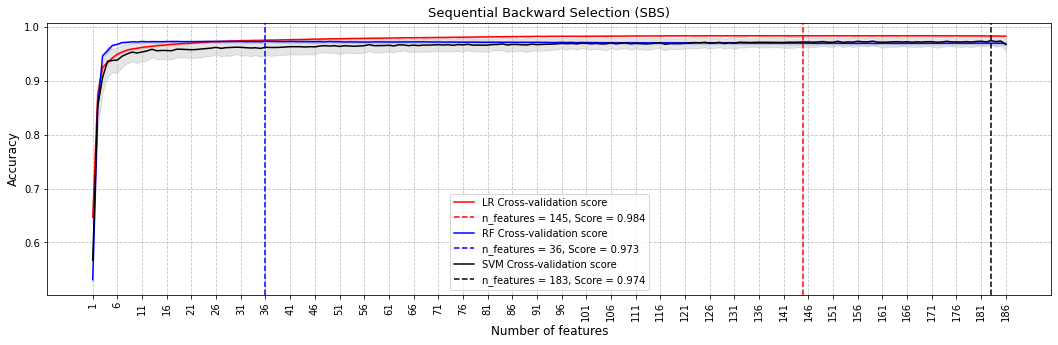

In [ ]:
steps_SFS = np.arange(len(SFS_RF_avg_score)) + 1
steps_SBS = np.arange(len(SFS_RF_avg_score)) + 1
steps_SFFS = np.arange(len(SFFS_RF_avg_score)) + 1

plt.figure(figsize=(18, 5))

############################### SBS ################################
# LR
plt.fill_between(steps_SFS, SBS_LR_avg_score - SBS_LR_ci_bound,
                 SBS_LR_avg_score + SBS_LR_ci_bound, alpha=0.1, color="red")
plt.plot(steps_SFS, SBS_LR_avg_score, '-', color="red", label="LR Cross-validation score")
plt.axvline(x=SBS_LR_avg_score.argmax() + 1, ls='--', color="red", label='n_features = {}, Score = {}'.format(SBS_LR_avg_score.argmax()+1, str(round(SBS_LR_avg_score.max(), 3))))

# RF
plt.fill_between(steps_SFS, SBS_RF_avg_score - SBS_RF_ci_bound,
                 SBS_RF_avg_score + SBS_RF_ci_bound, alpha=0.1, color="blue")
plt.plot(steps_SFS, SBS_RF_avg_score, '-', color="blue", label="RF Cross-validation score")
plt.axvline(x=SBS_RF_avg_score.argmax() + 1, ls='--', color="blue", label='n_features = {}, Score = {}'.format(SBS_RF_avg_score.argmax()+1, str(round(SBS_RF_avg_score.max(), 3))))

# SVM
plt.fill_between(steps_SFS, SBS_SVM_avg_score - SBS_SVM_ci_bound,
                 SBS_SVM_avg_score + SBS_SVM_ci_bound, alpha=0.1, color="black")
plt.plot(steps_SFS, SBS_SVM_avg_score, '-', color="black", label="SVM Cross-validation score")
plt.axvline(x=SBS_SVM_avg_score.argmax() + 1, ls='--', color="black", label='n_features = {}, Score = {}'.format(SBS_SVM_avg_score.argmax()+1, str(round(SBS_SVM_avg_score.max(), 3))))

# plt.xticks(ticks=np.arange(1, 187, 5), labels=SBS_LR_ordered_list[::5], rotation=90, fontsize=9)
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Number of features", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Sequential Backward Selection (SBS)", fontsize=13)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


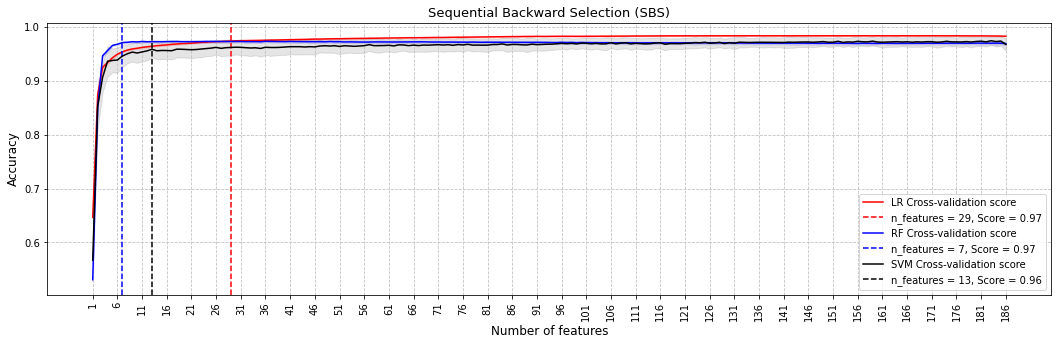

In [ ]:
stopping_critera = 0.002
steps_SBS = np.arange(len(SFS_RF_avg_score)) + 1

plt.figure(figsize=(18, 5))
####################################### LR #######################################
plt.fill_between(steps_SBS, SBS_LR_avg_score - SBS_LR_ci_bound,
                 SBS_LR_avg_score + SBS_LR_ci_bound, alpha=0.1, color="red")
plt.plot(steps_SBS, SBS_LR_avg_score, '-', color="red", label="LR Cross-validation score")
# plt.axvline(x=SBS_LR_avg_score.argmax() + 1, ls='--', color="red", label='n_features = {}, Score = {}'.format(SBS_LR_avg_score.argmax()+1, str(round(SBS_LR_avg_score.max(), 2))))

# selected features based on new stopping criteria
SBS_LR_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(SBS_LR_df.avg_score[i+9:i+10].values, SBS_LR_df.avg_score[i:i+1].values) < stopping_critera:
    SBS_LR_filtered_features_index = np.append(SBS_LR_filtered_features_index, i)
SBS_LR_number_features = SBS_LR_filtered_features_index.min() + 1

plt.axvline(x=int(SBS_LR_number_features), ls='--', color="red", label='n_features = {}, Score = {}'.format(int(SBS_LR_number_features), str(round(SBS_LR_avg_score[int(SBS_LR_number_features)], 2))))

####################################### RF #######################################
plt.fill_between(steps_SBS, SBS_RF_avg_score - SBS_RF_ci_bound,
                 SBS_RF_avg_score + SBS_RF_ci_bound, alpha=0.1, color="blue")
plt.plot(steps_SBS, SBS_RF_avg_score, '-', color="blue", label="RF Cross-validation score")
# plt.axvline(x=SBS_RF_avg_score.argmax() + 1, ls='--', color="blue", label='n_features = {}, Score = {}'.format(SBS_RF_avg_score.argmax()+1, str(round(SBS_RF_avg_score.max(), 2))))

# selected features based on new stopping criteria
SBS_RF_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(SBS_RF_df.avg_score[i+9:i+10].values, SBS_RF_df.avg_score[i:i+1].values) < stopping_critera:
    SBS_RF_filtered_features_index = np.append(SBS_RF_filtered_features_index, i)
SBS_RF_number_features = SBS_RF_filtered_features_index.min() + 1

plt.axvline(x=int(SBS_RF_number_features), ls='--', color="blue", label='n_features = {}, Score = {}'.format(int(SBS_RF_number_features), str(round(SBS_RF_avg_score[int(SBS_RF_number_features)], 2))))

####################################### SVM #######################################
plt.fill_between(steps_SBS, SBS_SVM_avg_score - SBS_SVM_ci_bound,
                 SBS_SVM_avg_score + SBS_SVM_ci_bound, alpha=0.1, color="black")
plt.plot(steps_SBS, SBS_SVM_avg_score, '-', color="black", label="SVM Cross-validation score")
# plt.axvline(x=SBS_SVM_avg_score.argmax() + 1, ls='--', color="black", label='n_features = {}, Score = {}'.format(SBS_SVM_avg_score.argmax()+1, str(round(SBS_SVM_avg_score.max(), 2))))

# selected features based on new stopping criteria
SBS_SVM_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(SBS_SVM_df.avg_score[i+9:i+10].values, SBS_SVM_df.avg_score[i:i+1].values) < stopping_critera:
    SBS_SVM_filtered_features_index = np.append(SBS_SVM_filtered_features_index, i)
SBS_SVM_number_features = SBS_SVM_filtered_features_index.min() + 1

plt.axvline(x=int(SBS_SVM_number_features), ls='--', color="black", label='n_features = {}, Score = {}'.format(int(SBS_SVM_number_features), str(round(SBS_SVM_avg_score[int(SBS_SVM_number_features)], 2))))


plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Number of features", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Sequential Backward Selection (SBS)", fontsize=13)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

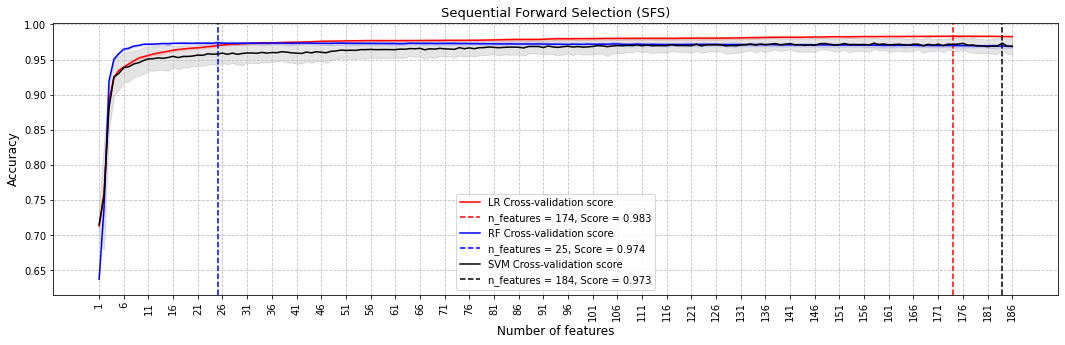

In [ ]:
steps_SFS = np.arange(len(SFS_RF_avg_score)) + 1
steps_SBS = np.arange(len(SFS_RF_avg_score)) + 1
steps_SFFS = np.arange(len(SFFS_RF_avg_score)) + 1

plt.figure(figsize=(18, 5))

############################### SFS ################################
# LR
plt.fill_between(steps_SFS, SFS_LR_avg_score - SFS_LR_ci_bound,
                 SFS_LR_avg_score + SFS_LR_ci_bound, alpha=0.1, color="red")
plt.plot(steps_SFS, SFS_LR_avg_score, '-', color="red", label="LR Cross-validation score")
plt.axvline(x=SFS_LR_avg_score.argmax() + 1, ls='--', color="red", label='n_features = {}, Score = {}'.format(SFS_LR_avg_score.argmax()+1, str(round(SFS_LR_avg_score.max(), 3))))

# RF
plt.fill_between(steps_SFS, SFS_RF_avg_score - SFS_RF_ci_bound,
                 SFS_RF_avg_score + SFS_RF_ci_bound, alpha=0.1, color="blue")
plt.plot(steps_SFS, SFS_RF_avg_score, '-', color="blue", label="RF Cross-validation score")
plt.axvline(x=SFS_RF_avg_score.argmax() + 1, ls='--', color="blue", label='n_features = {}, Score = {}'.format(SFS_RF_avg_score.argmax()+1, str(round(SFS_RF_avg_score.max(), 3))))

# SVM
plt.fill_between(steps_SFS, SFS_SVM_avg_score - SFS_SVM_ci_bound,
                 SFS_SVM_avg_score + SFS_SVM_ci_bound, alpha=0.1, color="black")
plt.plot(steps_SFS, SFS_SVM_avg_score, '-', color="black", label="SVM Cross-validation score")
plt.axvline(x=SFS_SVM_avg_score.argmax() + 1, ls='--', color="black", label='n_features = {}, Score = {}'.format(SFS_SVM_avg_score.argmax()+1, str(round(SFS_SVM_avg_score.max(), 3))))

plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Number of features", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Sequential Forward Selection (SFS)", fontsize=13)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


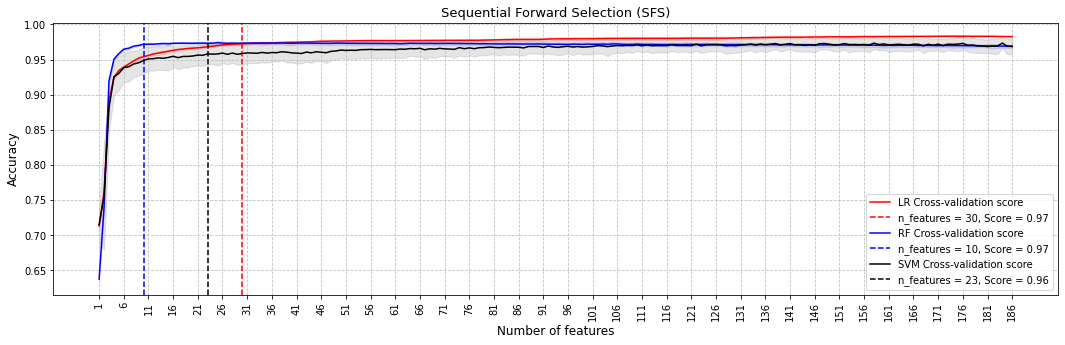

In [ ]:
stopping_critera = 0.002
steps_SFS = np.arange(len(SFS_RF_avg_score)) + 1

plt.figure(figsize=(18, 5))
####################################### LR #######################################
plt.fill_between(steps_SFS, SFS_LR_avg_score - SFS_LR_ci_bound,
                 SFS_LR_avg_score + SFS_LR_ci_bound, alpha=0.1, color="red")
plt.plot(steps_SFS, SFS_LR_avg_score, '-', color="red", label="LR Cross-validation score")
# plt.axvline(x=SFS_LR_avg_score.argmax() + 1, ls='--', color="red", label='n_features = {}, Score = {}'.format(SFS_LR_avg_score.argmax()+1, str(round(SFS_LR_avg_score.max(), 2))))

# selected features based on new stopping criteria
SFS_LR_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(SFS_LR_df.avg_score[i+9:i+10].values, SFS_LR_df.avg_score[i:i+1].values) < stopping_critera:
    SFS_LR_filtered_features_index = np.append(SFS_LR_filtered_features_index, i)
SFS_LR_number_features = SFS_LR_filtered_features_index.min() + 1

plt.axvline(x=int(SFS_LR_number_features), ls='--', color="red", label='n_features = {}, Score = {}'.format(int(SFS_LR_number_features), str(round(SFS_LR_avg_score[int(SFS_LR_number_features)], 2))))

####################################### RF #######################################
plt.fill_between(steps_SFS, SFS_RF_avg_score - SFS_RF_ci_bound,
                 SFS_RF_avg_score + SFS_RF_ci_bound, alpha=0.1, color="blue")
plt.plot(steps_SFS, SFS_RF_avg_score, '-', color="blue", label="RF Cross-validation score")
# plt.axvline(x=SFS_RF_avg_score.argmax() + 1, ls='--', color="blue", label='n_features = {}, Score = {}'.format(SFS_RF_avg_score.argmax()+1, str(round(SFS_RF_avg_score.max(), 2))))

# selected features based on new stopping criteria
SFS_RF_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(SFS_RF_df.avg_score[i+9:i+10].values, SFS_RF_df.avg_score[i:i+1].values) < stopping_critera:
    SFS_RF_filtered_features_index = np.append(SFS_RF_filtered_features_index, i)
SFS_RF_number_features = SFS_RF_filtered_features_index.min() + 1

plt.axvline(x=int(SFS_RF_number_features), ls='--', color="blue", label='n_features = {}, Score = {}'.format(int(SFS_RF_number_features), str(round(SFS_RF_avg_score[int(SFS_RF_number_features)], 2))))

####################################### SVM #######################################
plt.fill_between(steps_SFS, SFS_SVM_avg_score - SFS_SVM_ci_bound,
                 SFS_SVM_avg_score + SFS_SVM_ci_bound, alpha=0.1, color="black")
plt.plot(steps_SFS, SFS_SVM_avg_score, '-', color="black", label="SVM Cross-validation score")
# plt.axvline(x=SFS_SVM_avg_score.argmax() + 1, ls='--', color="black", label='n_features = {}, Score = {}'.format(SFS_SVM_avg_score.argmax()+1, str(round(SFS_SVM_avg_score.max(), 2))))

# selected features based on new stopping criteria
SFS_SVM_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(SFS_SVM_df.avg_score[i+9:i+10].values, SFS_SVM_df.avg_score[i:i+1].values) < stopping_critera:
    SFS_SVM_filtered_features_index = np.append(SFS_SVM_filtered_features_index, i)
SFS_SVM_number_features = SFS_SVM_filtered_features_index.min() + 1

plt.axvline(x=int(SFS_SVM_number_features), ls='--', color="black", label='n_features = {}, Score = {}'.format(int(SFS_SVM_number_features), str(round(SFS_SVM_avg_score[int(SFS_SVM_number_features)], 2))))


plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Number of features", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Sequential Forward Selection (SFS)", fontsize=13)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

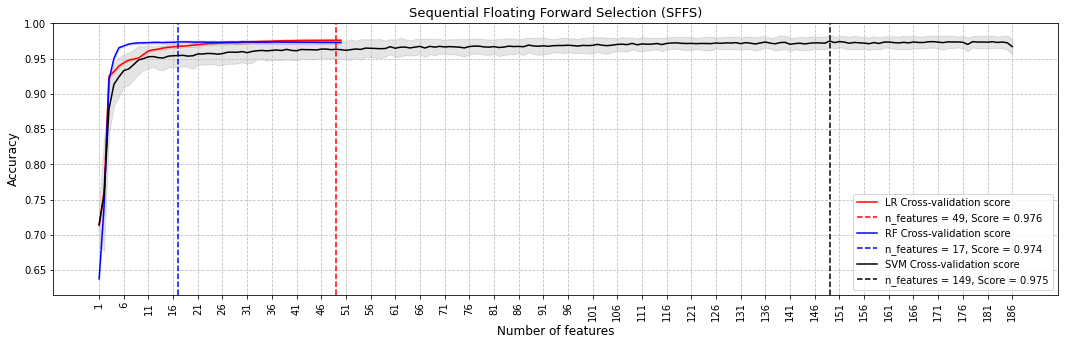

In [ ]:
steps_SFS = np.arange(len(SFS_RF_avg_score)) + 1
steps_SBS = np.arange(len(SFS_RF_avg_score)) + 1
steps_SFFS = np.arange(len(SFFS_RF_avg_score)) + 1

plt.figure(figsize=(18, 5))

############################### SFS ################################
# LR
plt.fill_between(steps_SFFS, SFFS_LR_avg_score - SFFS_LR_ci_bound,
                 SFFS_LR_avg_score + SFFS_LR_ci_bound, alpha=0.1, color="red")
plt.plot(steps_SFFS, SFFS_LR_avg_score, '-', color="red", label="LR Cross-validation score")
plt.axvline(x=SFFS_LR_avg_score.argmax() + 1, ls='--', color="red", label='n_features = {}, Score = {}'.format(SFFS_LR_avg_score.argmax()+1, str(round(SFFS_LR_avg_score.max(), 3))))

# RF
plt.fill_between(steps_SFFS, SFFS_RF_avg_score - SFFS_RF_ci_bound,
                 SFFS_RF_avg_score + SFFS_RF_ci_bound, alpha=0.1, color="blue")
plt.plot(steps_SFFS, SFFS_RF_avg_score, '-', color="blue", label="RF Cross-validation score")
plt.axvline(x=SFFS_RF_avg_score.argmax() + 1, ls='--', color="blue", label='n_features = {}, Score = {}'.format(SFFS_RF_avg_score.argmax()+1, str(round(SFFS_RF_avg_score.max(), 3))))

# SVM
plt.fill_between(steps_SFS, SFFS_SVM_avg_score - SFFS_SVM_ci_bound,
                 SFFS_SVM_avg_score + SFFS_SVM_ci_bound, alpha=0.1, color="black")
plt.plot(steps_SFS, SFFS_SVM_avg_score, '-', color="black", label="SVM Cross-validation score")
plt.axvline(x=SFFS_SVM_avg_score.argmax() + 1, ls='--', color="black", label='n_features = {}, Score = {}'.format(SFFS_SVM_avg_score.argmax()+1, str(round(SFFS_SVM_avg_score.max(), 3))))

plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Number of features", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Sequential Floating Forward Selection (SFFS)", fontsize=13)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


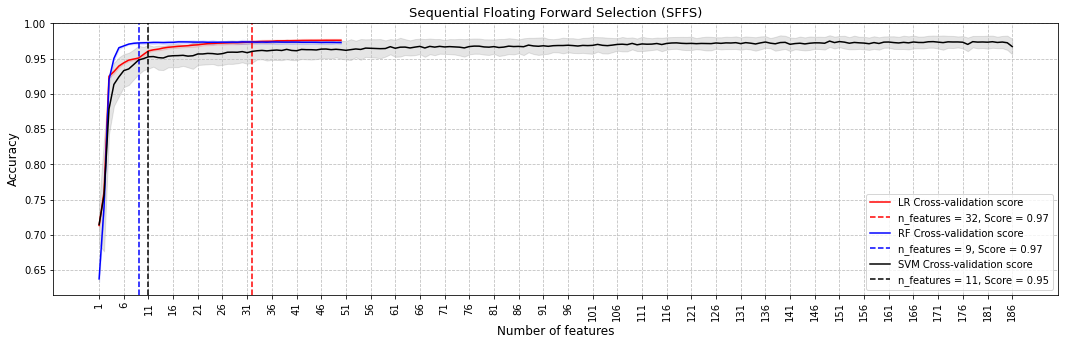

In [ ]:
stopping_critera = 0.002
steps_SFFS = np.arange(len(SFFS_SVM_avg_score)) + 1
steps_SFFS_50 = np.arange(50) + 1

plt.figure(figsize=(18, 5))
####################################### LR #######################################
plt.fill_between(steps_SFFS_50, SFFS_LR_avg_score - SFFS_LR_ci_bound,
                 SFFS_LR_avg_score + SFFS_LR_ci_bound, alpha=0.1, color="red")
plt.plot(steps_SFFS_50, SFFS_LR_avg_score, '-', color="red", label="LR Cross-validation score")
# plt.axvline(x=SFFS_LR_avg_score.argmax() + 1, ls='--', color="red", label='n_features = {}, Score = {}'.format(SFFS_LR_avg_score.argmax()+1, str(round(SFFS_LR_avg_score.max(), 2))))

# selected features based on new stopping criteria
SFFS_LR_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(SFFS_LR_df.avg_score[i+9:i+10].values, SFFS_LR_df.avg_score[i:i+1].values) < stopping_critera:
    SFFS_LR_filtered_features_index = np.append(SFFS_LR_filtered_features_index, i)
SFFS_LR_number_features = SFFS_LR_filtered_features_index.min() + 1

plt.axvline(x=int(SFFS_LR_number_features), ls='--', color="red", label='n_features = {}, Score = {}'.format(int(SFFS_LR_number_features), str(round(SFFS_LR_avg_score[int(SFFS_LR_number_features)], 2))))

####################################### RF #######################################
plt.fill_between(steps_SFFS_50, SFFS_RF_avg_score - SFFS_RF_ci_bound,
                 SFFS_RF_avg_score + SFFS_RF_ci_bound, alpha=0.1, color="blue")
plt.plot(steps_SFFS_50, SFFS_RF_avg_score, '-', color="blue", label="RF Cross-validation score")
# plt.axvline(x=SFFS_RF_avg_score.argmax() + 1, ls='--', color="blue", label='n_features = {}, Score = {}'.format(SFFS_RF_avg_score.argmax()+1, str(round(SFFS_RF_avg_score.max(), 2))))

# selected features based on new stopping criteria
SFFS_RF_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(SFFS_RF_df.avg_score[i+9:i+10].values, SFFS_RF_df.avg_score[i:i+1].values) < stopping_critera:
    SFFS_RF_filtered_features_index = np.append(SFFS_RF_filtered_features_index, i)
SFFS_RF_number_features = SFFS_RF_filtered_features_index.min() + 1

plt.axvline(x=int(SFFS_RF_number_features), ls='--', color="blue", label='n_features = {}, Score = {}'.format(int(SFFS_RF_number_features), str(round(SFFS_RF_avg_score[int(SFFS_RF_number_features)], 2))))

####################################### SVM #######################################
plt.fill_between(steps_SFFS, SFFS_SVM_avg_score - SFFS_SVM_ci_bound,
                 SFFS_SVM_avg_score + SFFS_SVM_ci_bound, alpha=0.1, color="black")
plt.plot(steps_SFFS, SFFS_SVM_avg_score, '-', color="black", label="SVM Cross-validation score")
# plt.axvline(x=SFFS_SVM_avg_score.argmax() + 1, ls='--', color="black", label='n_features = {}, Score = {}'.format(SFFS_SVM_avg_score.argmax()+1, str(round(SFFS_SVM_avg_score.max(), 2))))

# selected features based on new stopping criteria
SFFS_SVM_filtered_features_index = np.array([])
for i in range(186):
  if np.subtract(SFFS_SVM_df.avg_score[i+9:i+10].values, SFFS_SVM_df.avg_score[i:i+1].values) < stopping_critera:
    SFFS_SVM_filtered_features_index = np.append(SFFS_SVM_filtered_features_index, i)
SFFS_SVM_number_features = SFFS_SVM_filtered_features_index.min() + 1

plt.axvline(x=int(SFFS_SVM_number_features), ls='--', color="black", label='n_features = {}, Score = {}'.format(int(SFFS_SVM_number_features), str(round(SFFS_SVM_avg_score[int(SFFS_SVM_number_features)], 2))))


plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)

plt.xlabel("Number of features", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Sequential Floating Forward Selection (SFFS)", fontsize=13)
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

In [ ]:
list_of_methods = ['SFS_LR', 'SFS_RF', 'SFS_SVM',
                   'SBS_LR', 'SBS_RF', 'SBS_SVM',
                   'SFFS_LR', 'SFFS_RF', 'SFFS_SVM']

In [ ]:
number_of_features = [SFS_LR_number_features, SFS_RF_number_features, SFS_SVM_number_features,
                      SBS_LR_number_features, SBS_RF_number_features, SBS_SVM_number_features,
                      SFFS_LR_number_features, SFFS_RF_number_features, SFFS_SVM_number_features]

# Jaccard

In [ ]:
SBS_LR_df.head(3)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(78,)","[0.6462754889721182, 0.6454815695600475, 0.647...",0.646663,"(Band_079,)",0.000896423,0.000697447,0.000348724
2,"(78, 91)","[0.875334403424291, 0.8742568370986921, 0.8724...",0.874068,"(Band_079, Band_092)",0.00286286,0.0022274,0.0011137
3,"(43, 78, 91)","[0.9270554663813091, 0.9197384066587396, 0.922...",0.924864,"(Band_044, Band_079, Band_092)",0.00430589,0.00335013,0.00167507


### Jaccard based on highest performance stopping critera

In [ ]:
# sorted list of selected bands
SBS_LR = list(SBS_LR_df.feature_names[SBS_LR_df.avg_score.values.argmax() + 1])
SBS_RF = list(SBS_RF_df.feature_names[SBS_RF_df.avg_score.values.argmax() + 1])
SBS_SVM = list(SBS_SVM_df.feature_names[SBS_SVM_df.avg_score.values.argmax() + 1])

SFS_LR = list(SFS_LR_df.feature_names[SFS_LR_df.avg_score.values.argmax() + 1])
SFS_RF = list(SFS_RF_df.feature_names[SFS_RF_df.avg_score.values.argmax() + 1])
SFS_SVM = list(SFS_SVM_df.feature_names[SFS_SVM_df.avg_score.values.argmax() + 1])

SFFS_LR = list(SFFS_LR_df.feature_names[SFFS_LR_df.avg_score.values.argmax() + 1])
SFFS_RF = list(SFFS_RF_df.feature_names[SFFS_RF_df.avg_score.values.argmax() + 1])
SFFS_SVM = list(SFFS_SVM_df.feature_names[SFFS_SVM_df.avg_score.values.argmax() + 1])

In [ ]:
methods = [SFS_LR, SFS_RF, SFS_SVM,
                   SBS_LR, SBS_RF, SBS_SVM,
                   SFFS_LR, SFFS_RF, SFFS_SVM]

In [ ]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

In [ ]:
jacc_matrix = np.array([])
for x in methods:
  for y in methods:
    jacc_matrix = np.append(jacc_matrix, jaccard_similarity(x, y))

jacc_matrix = jacc_matrix.reshape((9, -1))

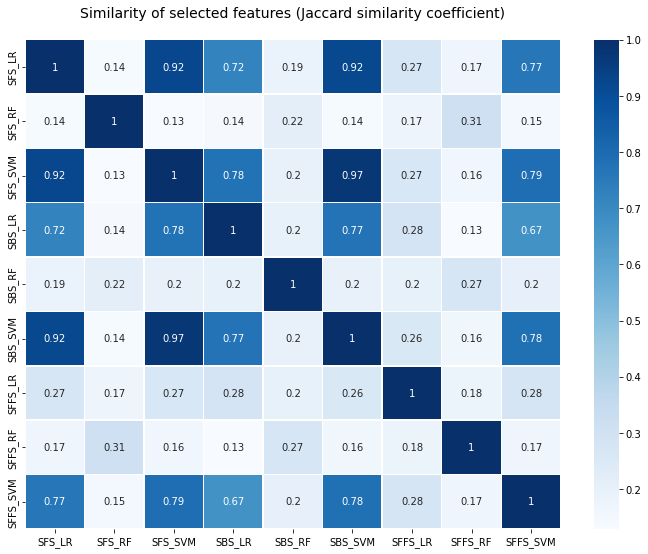

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns_plot = sns.heatmap(data=jacc_matrix, annot=True, linewidths=.5, cmap='Blues',
                       xticklabels=list_of_methods, yticklabels=list_of_methods, ax=ax)
# sns_plot.figure.savefig("../../Images/plots/correlations/" + "Band_001 to Band_012" + ".png")
plt.title('Similarity of selected features (Jaccard similarity coefficient)\n', fontsize=14)
plt.show()

### Jaccard based on new stopping critera

In [ ]:
# sorted list of selected bands
SBS_LR = list(SBS_LR_df.feature_names[int(SBS_LR_number_features+1)])
SBS_RF = list(SBS_RF_df.feature_names[int(SBS_RF_number_features+1)])
SBS_SVM = list(SBS_SVM_df.feature_names[int(SBS_SVM_number_features+1)])

SFS_LR = list(SFS_LR_df.feature_names[int(SFS_LR_number_features+1)])
SFS_RF = list(SFS_RF_df.feature_names[int(SFS_RF_number_features+1)])
SFS_SVM = list(SFS_SVM_df.feature_names[int(SFS_SVM_number_features+1)])

SFFS_LR = list(SFFS_LR_df.feature_names[int(SFFS_LR_number_features+1)])
SFFS_RF = list(SFFS_RF_df.feature_names[int(SFFS_RF_number_features+1)])
SFFS_SVM = list(SFFS_SVM_df.feature_names[int(SFFS_SVM_number_features+1)])

In [ ]:
methods = [SFS_LR, SFS_RF, SFS_SVM,
                   SBS_LR, SBS_RF, SBS_SVM,
                   SFFS_LR, SFFS_RF, SFFS_SVM]

In [ ]:
jaccard_similarity(SFFS_LR, SFS_LR)

0.5609756097560976

In [ ]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

In [ ]:
jacc_matrix = np.array([])
for x in methods:
  for y in methods:
    jacc_matrix = np.append(jacc_matrix, jaccard_similarity(x, y))

jacc_matrix = jacc_matrix.reshape((9, -1))

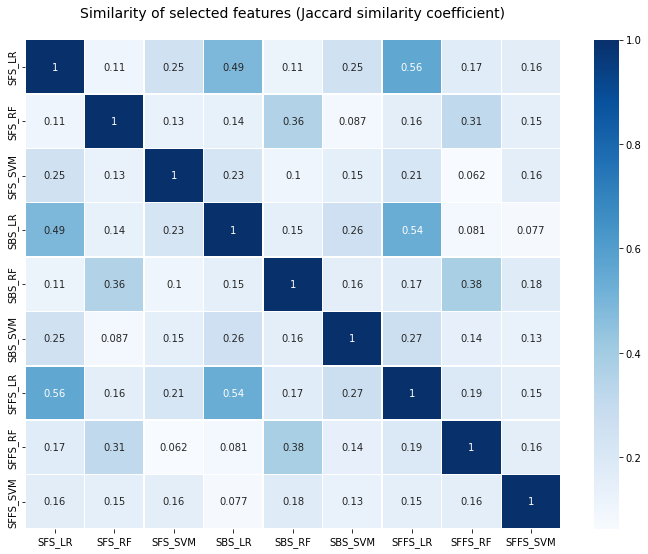

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns_plot = sns.heatmap(data=jacc_matrix, annot=True, linewidths=.5, cmap='Blues',
                       xticklabels=list_of_methods, yticklabels=list_of_methods, ax=ax)
# sns_plot.figure.savefig("../../Images/plots/correlations/" + "Band_001 to Band_012" + ".png")
plt.title('Similarity of selected features (Jaccard similarity coefficient)\n', fontsize=14)
plt.show()

# get orders of selected features

## based on highest performance

#### CBS

In [ ]:
# ordered list of selected bands
SBS_LR_number_of_features = SBS_LR_df.avg_score.values.argmax() + 1

SBS_LR_ordered_list = list(set(SBS_LR_df.feature_names.values[0]))
for i in range(SBS_LR_number_of_features - 1):
  band = list(set(SBS_LR_df.feature_names.values[i+1]) - set(SBS_LR_df.feature_names.values[i]))
  SBS_LR_ordered_list.append(band[0])

# SBS_LR_ordered_list


# ordered list of selected bands
SBS_SVM_number_of_features = SBS_SVM_df.avg_score.values.argmax() + 1

SBS_SVM_ordered_list = list(set(SBS_SVM_df.feature_names.values[0]))
for i in range(SBS_SVM_number_of_features - 1):
  band = list(set(SBS_SVM_df.feature_names.values[i+1]) - set(SBS_SVM_df.feature_names.values[i]))
  SBS_SVM_ordered_list.append(band[0])

# SBS_SVM_ordered_list


# ordered list of selected bands
SBS_RF_number_of_features = SBS_RF_df.avg_score.values.argmax() + 1

SBS_RF_ordered_list = list(set(SBS_RF_df.feature_names.values[0]))
for i in range(SBS_RF_number_of_features - 1):
  band = list(set(SBS_RF_df.feature_names.values[i+1]) - set(SBS_RF_df.feature_names.values[i]))
  SBS_RF_ordered_list.append(band[0])

# SBS_SVM_ordered_list

In [ ]:
feature_names = np.array(list(set(SBS_LR_df.feature_names[-1:]))).flatten()

In [ ]:
df = pd.DataFrame(data=feature_names, columns=['features'])

In [ ]:
helper_df = pd.DataFrame(data=SBS_LR_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SBS_LR', value=np.arange(186, 186 - len(SBS_LR_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
helper_df = pd.DataFrame(data=SBS_RF_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SBS_RF', value=np.arange(186, 186 - len(SBS_RF_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
helper_df = pd.DataFrame(data=SBS_SVM_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SBS_SVM', value=np.arange(186, 186 - len(SBS_SVM_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
df.fillna(value=0, inplace=True)

In [ ]:
df.head(3)

,features,SBS_LR,SBS_RF,SBS_SVM
0,Band_001,0.0,0.0,120.0
1,Band_002,65.0,0.0,17.0
2,Band_003,84.0,0.0,158.0


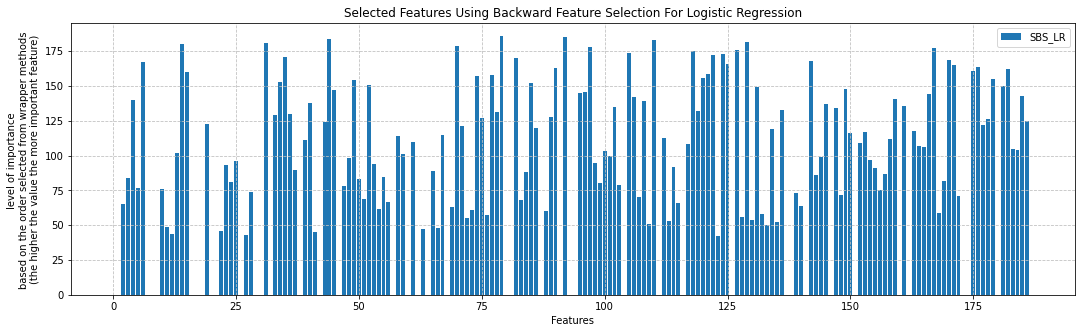

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SBS_LR, label="SBS_LR")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Backward Feature Selection For Logistic Regression')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

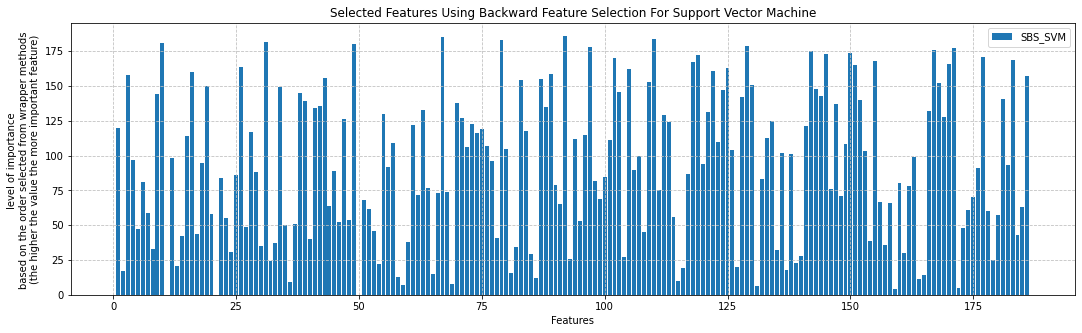

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SBS_SVM, label="SBS_SVM")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Backward Feature Selection For Support Vector Machine')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

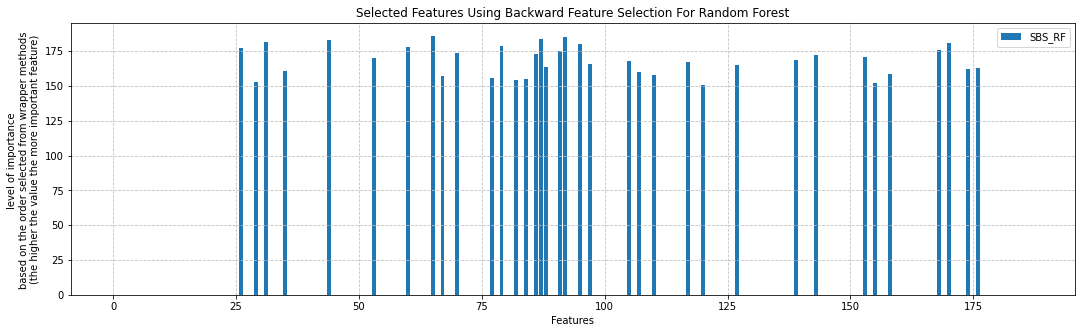

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SBS_RF, label="SBS_RF")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Backward Feature Selection For Random Forest')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

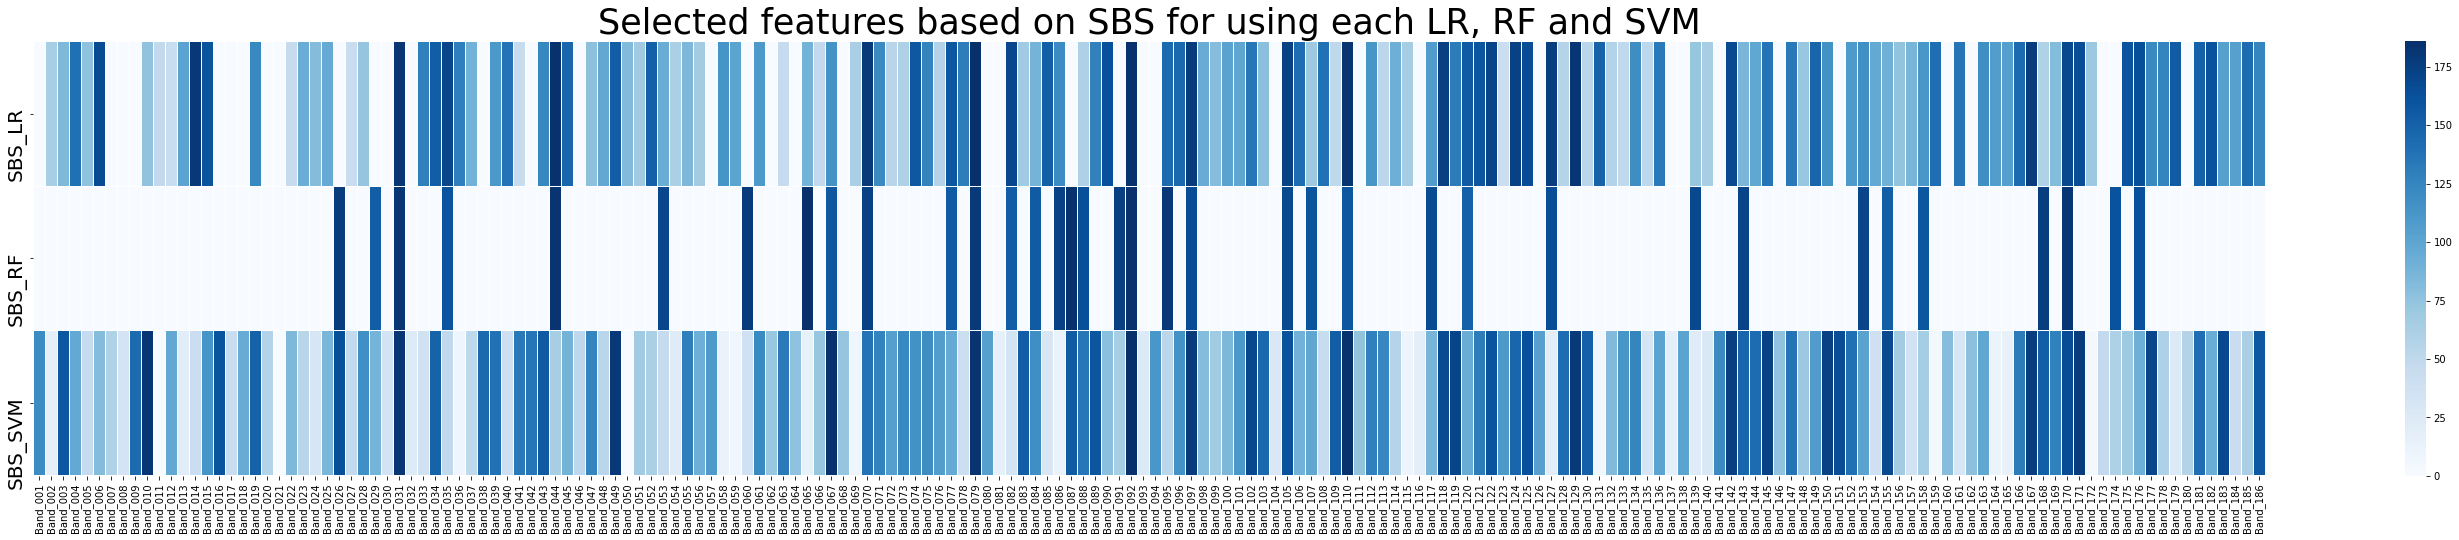

In [ ]:
fig, ax = plt.subplots(figsize=(50,8))
# ax.set_title('')
sns_plot = sns.heatmap(data=np.transpose(df.iloc[:,1:].values), annot=False, linewidths=0.01, cmap='Blues',
                       xticklabels=df.features.values[:], yticklabels=df.columns.values[1:], ax=ax)
plt.title('Selected features based on SBS for using each LR, RF and SVM', fontsize=35)
plt.yticks(fontsize=20)

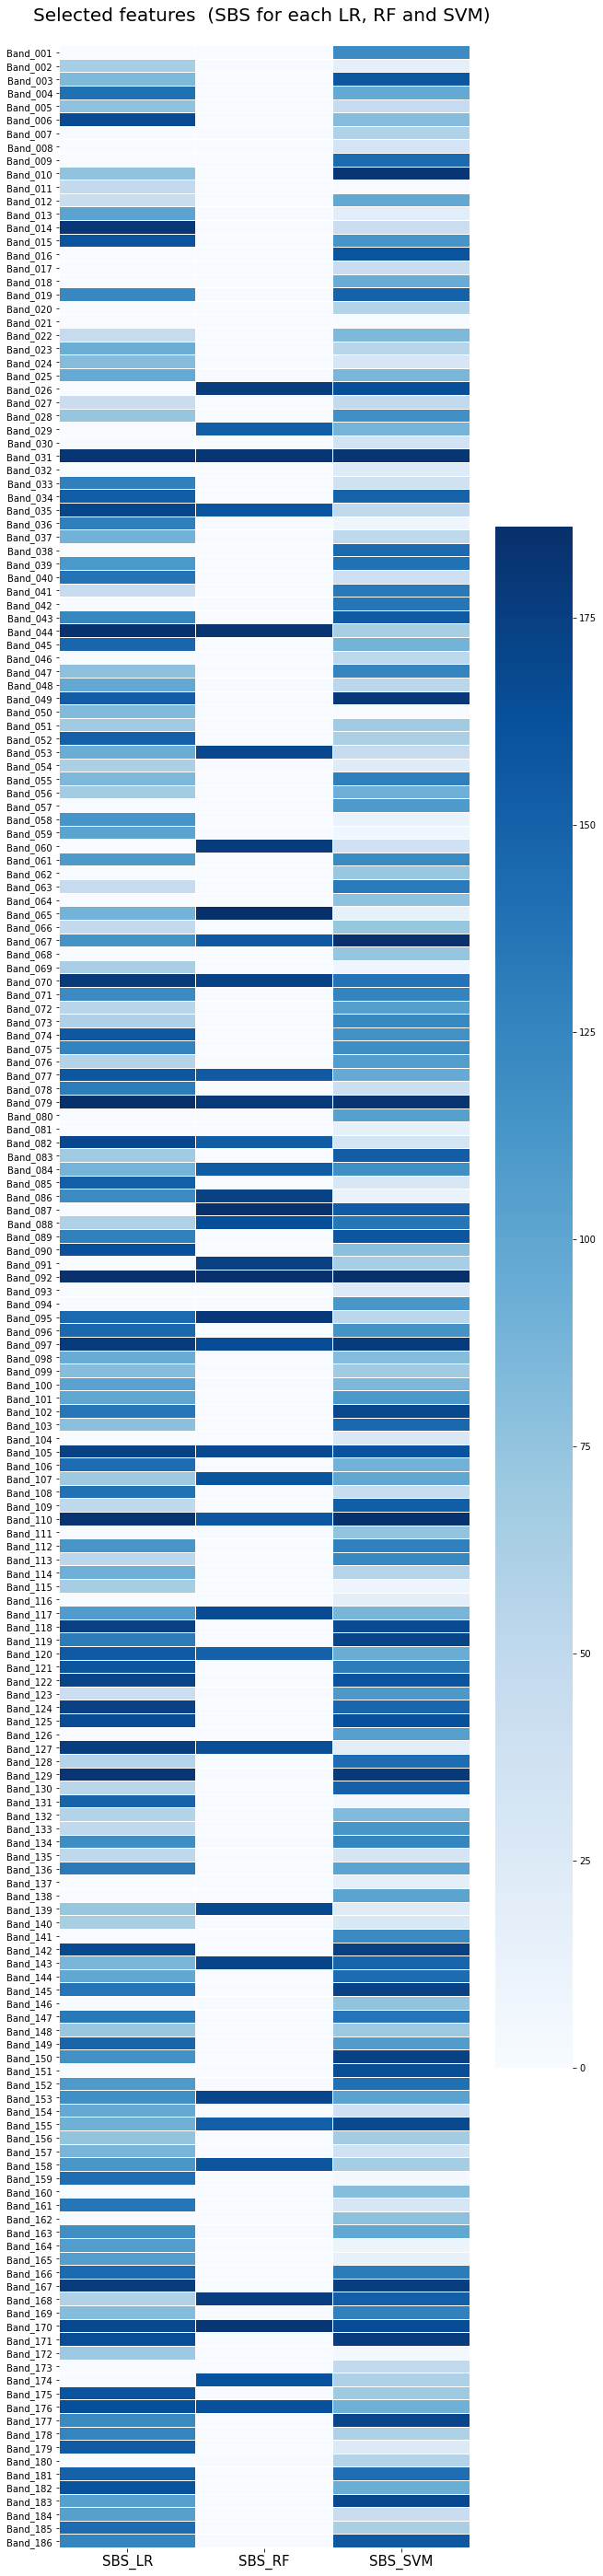

In [ ]:
fig, ax = plt.subplots(figsize=(10,50))
# ax.set_title('')
sns_plot = sns.heatmap(data=df.iloc[:,1:].values, annot=False, linewidths=0.01, cmap='Blues', 
                       yticklabels=df.features.values[:], xticklabels=df.columns.values[1:], ax=ax)

plt.title('Selected features  (SBS for each LR, RF and SVM) \n', fontsize=20)
plt.xticks(fontsize=15)
# plt.yticks(fontsize=20)
plt.show()

####SFS

In [ ]:
# ordered list of selected bands
SFS_LR_number_of_features = SFS_LR_df.avg_score.values.argmax() + 1

SFS_LR_ordered_list = list(set(SFS_LR_df.feature_names.values[0]))
for i in range(SFS_LR_number_of_features - 1):
  band = list(set(SFS_LR_df.feature_names.values[i+1]) - set(SFS_LR_df.feature_names.values[i]))
  SFS_LR_ordered_list.append(band[0])

# SFS_LR_ordered_list


# ordered list of selected bands
SFS_SVM_number_of_features = SFS_SVM_df.avg_score.values.argmax() + 1

SFS_SVM_ordered_list = list(set(SFS_SVM_df.feature_names.values[0]))
for i in range(SFS_SVM_number_of_features - 1):
  band = list(set(SFS_SVM_df.feature_names.values[i+1]) - set(SFS_SVM_df.feature_names.values[i]))
  SFS_SVM_ordered_list.append(band[0])

# SFS_SVM_ordered_list


# ordered list of selected bands
SFS_RF_number_of_features = SFS_RF_df.avg_score.values.argmax() + 1

SFS_RF_ordered_list = list(set(SFS_RF_df.feature_names.values[0]))
for i in range(SFS_RF_number_of_features - 1):
  band = list(set(SFS_RF_df.feature_names.values[i+1]) - set(SFS_RF_df.feature_names.values[i]))
  SFS_RF_ordered_list.append(band[0])

# SFS_SVM_ordered_list

In [ ]:
feature_names = np.array(list(set(SFS_LR_df.feature_names[-1:]))).flatten()

In [ ]:
df = pd.DataFrame(data=feature_names, columns=['features'])

In [ ]:
helper_df = pd.DataFrame(data=SFS_LR_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SFS_LR', value=np.arange(186, 186 - len(SFS_LR_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
helper_df = pd.DataFrame(data=SFS_RF_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SFS_RF', value=np.arange(186, 186 - len(SFS_RF_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
helper_df = pd.DataFrame(data=SFS_SVM_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SFS_SVM', value=np.arange(186, 186 - len(SFS_SVM_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
df.fillna(value=0, inplace=True)

In [ ]:
df.head(3)

,features,SFS_LR,SFS_RF,SFS_SVM
0,Band_001,0.0,0.0,110.0
1,Band_002,71.0,0.0,20.0
2,Band_003,86.0,0.0,93.0


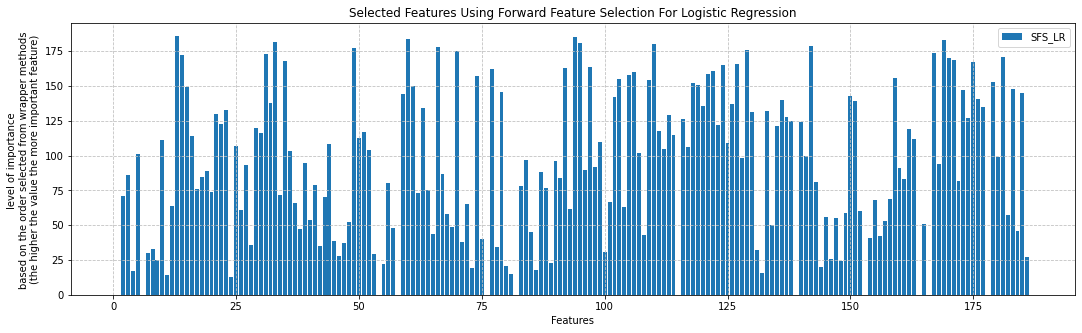

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SFS_LR, label="SFS_LR")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Forward Feature Selection For Logistic Regression')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

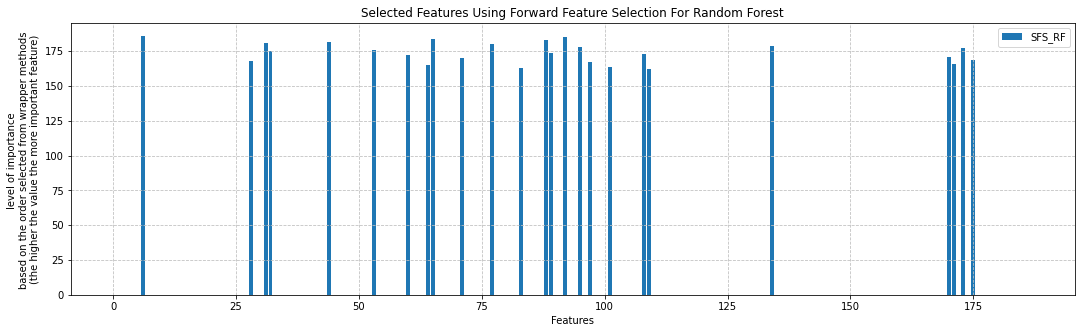

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SFS_RF, label="SFS_RF")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Forward Feature Selection For Random Forest')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

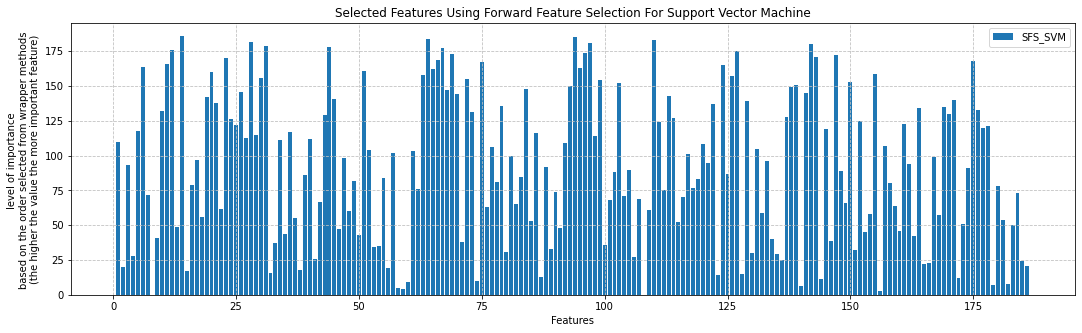

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SFS_SVM, label="SFS_SVM")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Forward Feature Selection For Support Vector Machine')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

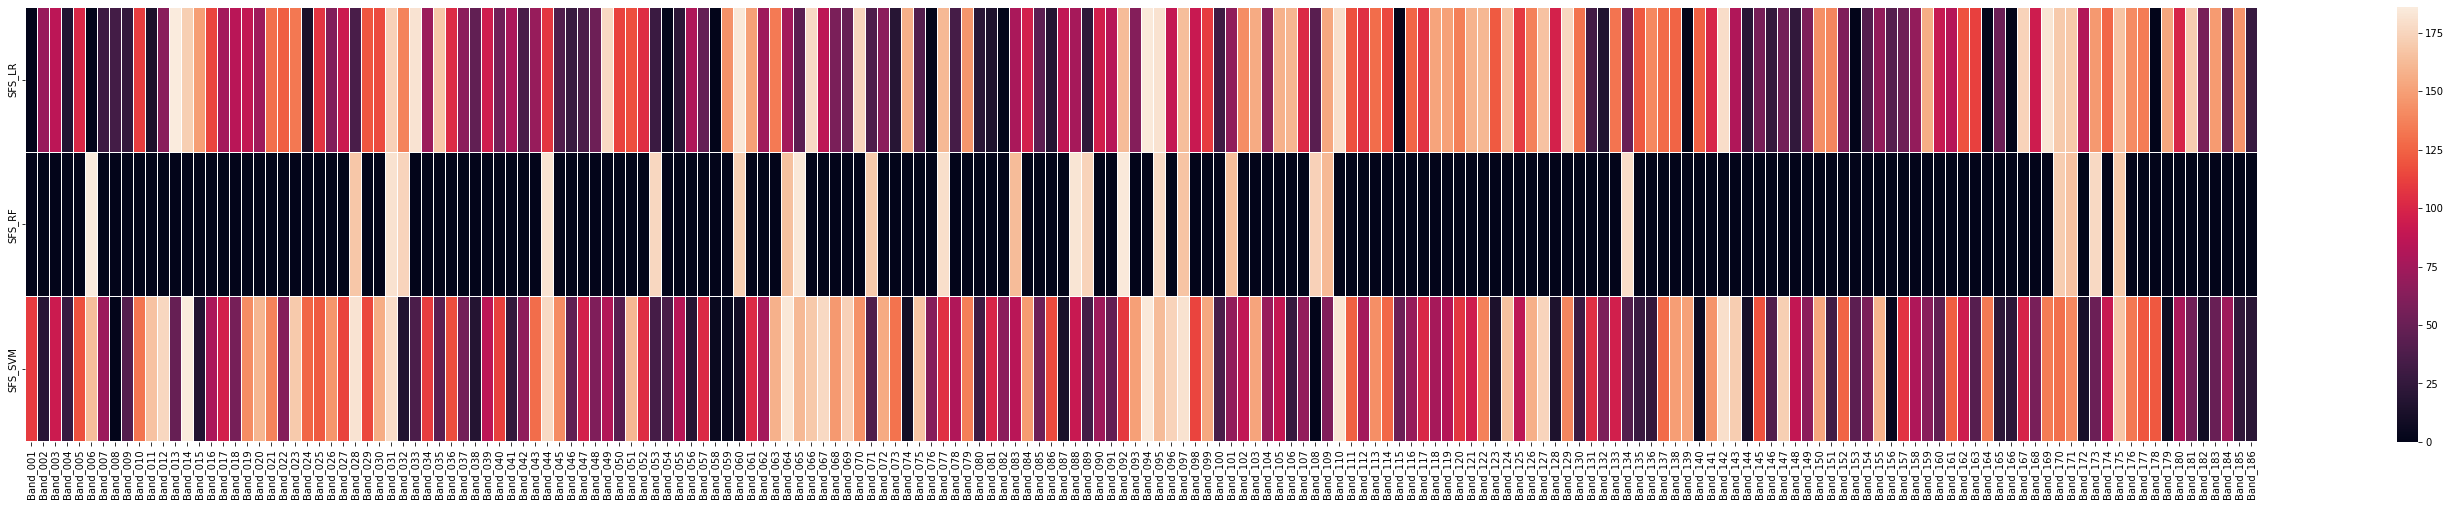

In [ ]:
fig, ax = plt.subplots(figsize=(50,8))
# ax.set_title('')
sns_plot = sns.heatmap(data=np.transpose(df.iloc[:,1:].values), annot=False, linewidths=0.01, 
                       xticklabels=df.features.values[:], yticklabels=df.columns.values[1:], ax=ax)

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

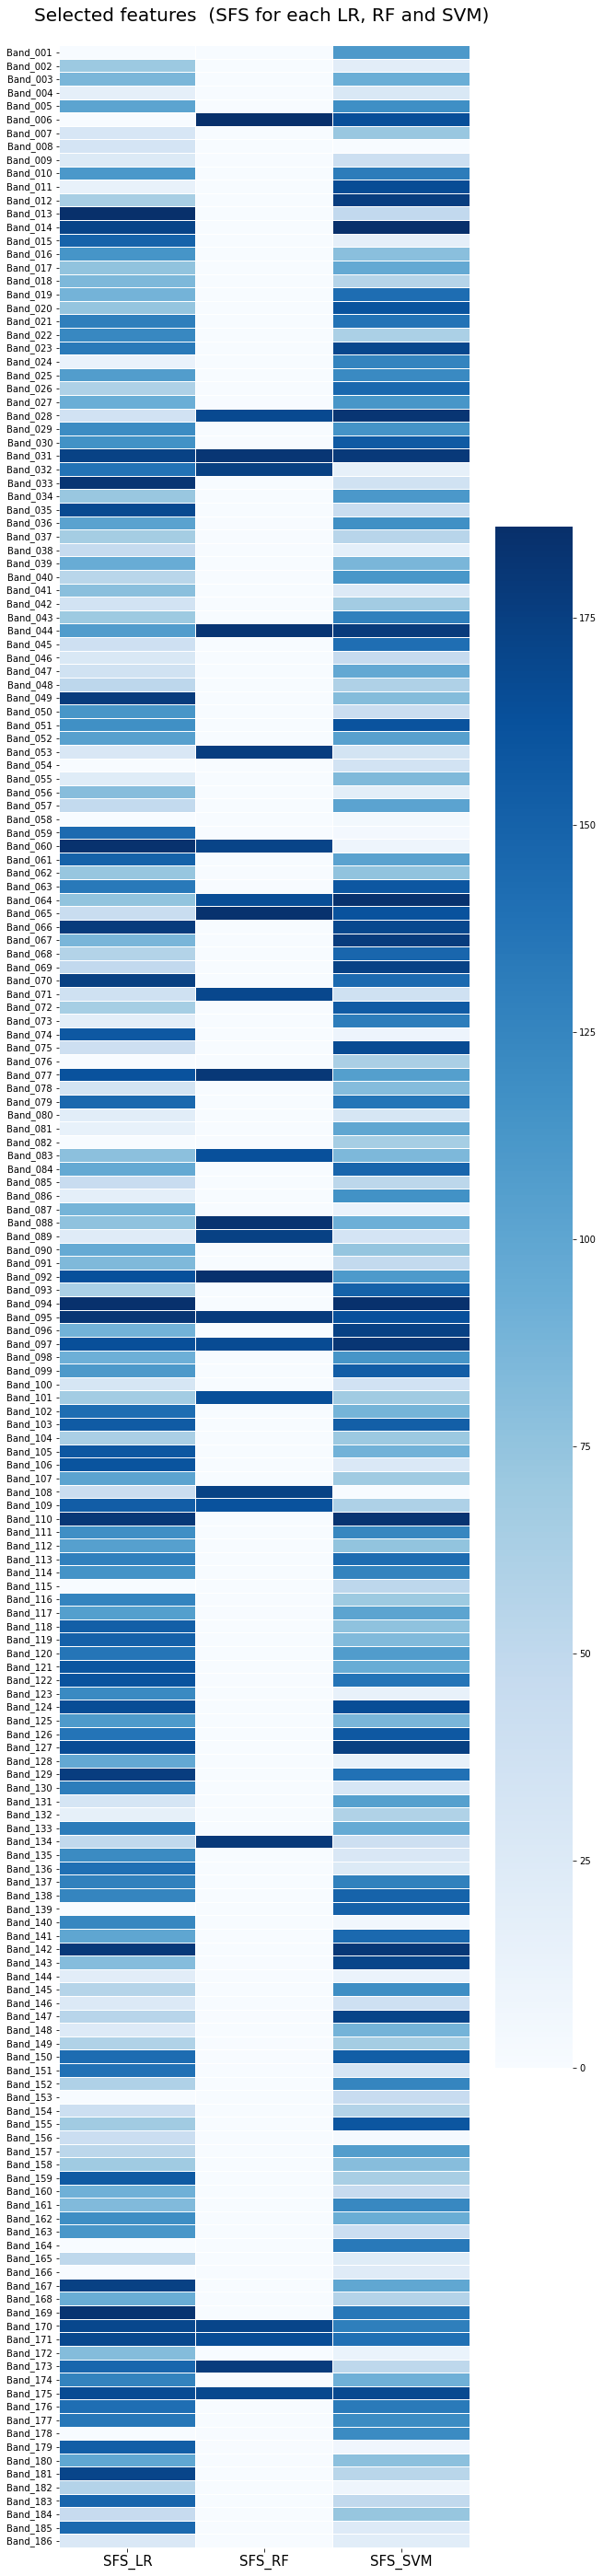

In [ ]:
fig, ax = plt.subplots(figsize=(10,50))
# ax.set_title('')
sns_plot = sns.heatmap(data=df.iloc[:,1:].values, annot=False, linewidths=0.01, cmap='Blues',
                       yticklabels=df.features.values[:], xticklabels=df.columns.values[1:], ax=ax)
plt.title('Selected features  (SFS for each LR, RF and SVM) \n', fontsize=20)
plt.xticks(fontsize=15)

## based on new stopping critera

### SBS

In [ ]:
number_of_features = [SFS_LR_number_features, SFS_RF_number_features, SFS_SVM_number_features,
                      SBS_LR_number_features, SBS_RF_number_features, SBS_SVM_number_features,
                      SFFS_LR_number_features, SFFS_RF_number_features, SFFS_SVM_number_features]

In [ ]:
# ordered list of selected bands
SBS_LR_number_of_features = int(SBS_LR_number_features)

SBS_LR_ordered_list = list(set(SBS_LR_df.feature_names.values[0]))
for i in range(SBS_LR_number_of_features - 1):
  band = list(set(SBS_LR_df.feature_names.values[i+1]) - set(SBS_LR_df.feature_names.values[i]))
  SBS_LR_ordered_list.append(band[0])

# SBS_LR_ordered_list


# ordered list of selected bands
SBS_SVM_number_of_features = int(SBS_SVM_number_features)

SBS_SVM_ordered_list = list(set(SBS_SVM_df.feature_names.values[0]))
for i in range(SBS_SVM_number_of_features - 1):
  band = list(set(SBS_SVM_df.feature_names.values[i+1]) - set(SBS_SVM_df.feature_names.values[i]))
  SBS_SVM_ordered_list.append(band[0])

# SBS_SVM_ordered_list


# ordered list of selected bands
SBS_RF_number_of_features = int(SBS_RF_number_features)

SBS_RF_ordered_list = list(set(SBS_RF_df.feature_names.values[0]))
for i in range(SBS_RF_number_of_features - 1):
  band = list(set(SBS_RF_df.feature_names.values[i+1]) - set(SBS_RF_df.feature_names.values[i]))
  SBS_RF_ordered_list.append(band[0])

# SBS_SVM_ordered_list

In [ ]:
feature_names = np.array(list(set(SBS_LR_df.feature_names[-1:]))).flatten()

In [ ]:
df = pd.DataFrame(data=feature_names, columns=['features'])

In [ ]:
helper_df = pd.DataFrame(data=SBS_LR_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SBS_LR', value=np.arange(186, 186 - len(SBS_LR_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
helper_df = pd.DataFrame(data=SBS_RF_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SBS_RF', value=np.arange(186, 186 - len(SBS_RF_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
helper_df = pd.DataFrame(data=SBS_SVM_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SBS_SVM', value=np.arange(186, 186 - len(SBS_SVM_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
df.fillna(value=0, inplace=True)

In [ ]:
df.head(3)

,features,SBS_LR,SBS_RF,SBS_SVM
0,Band_001,0.0,0.0,0.0
1,Band_002,0.0,0.0,0.0
2,Band_003,0.0,0.0,0.0


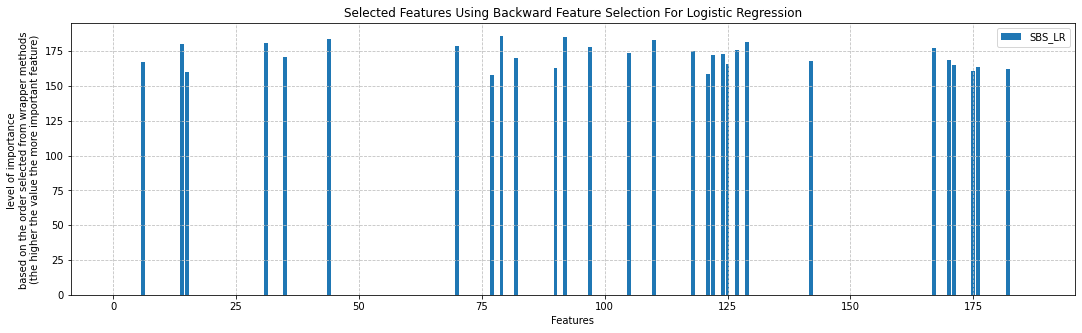

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SBS_LR, label="SBS_LR")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Backward Feature Selection For Logistic Regression')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

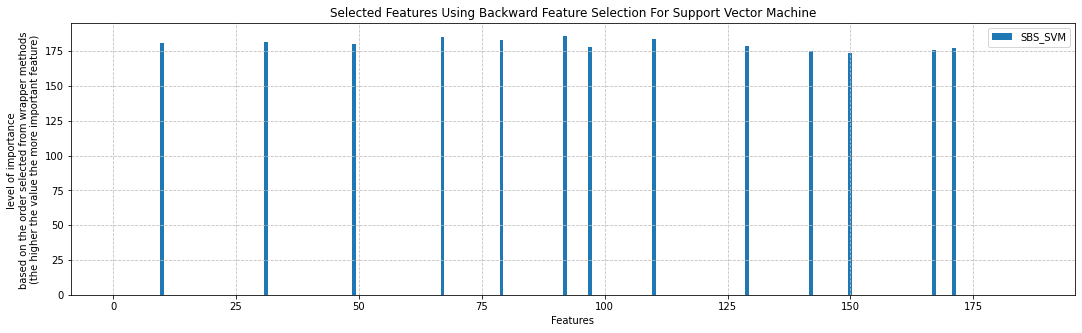

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SBS_SVM, label="SBS_SVM")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Backward Feature Selection For Support Vector Machine')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

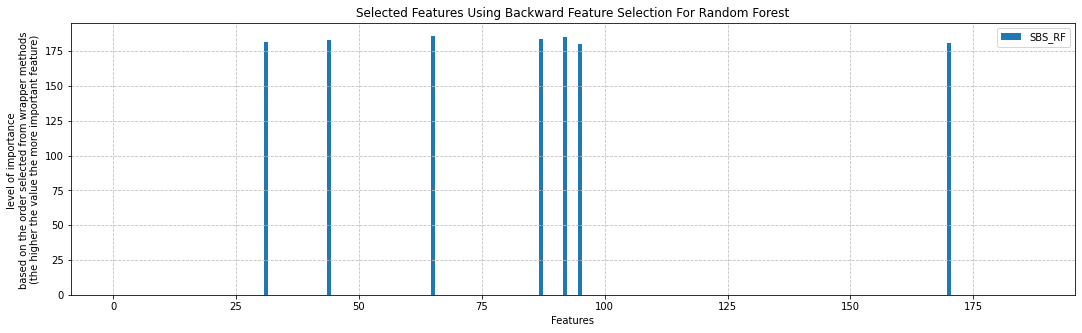

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SBS_RF, label="SBS_RF")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Backward Feature Selection For Random Forest')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

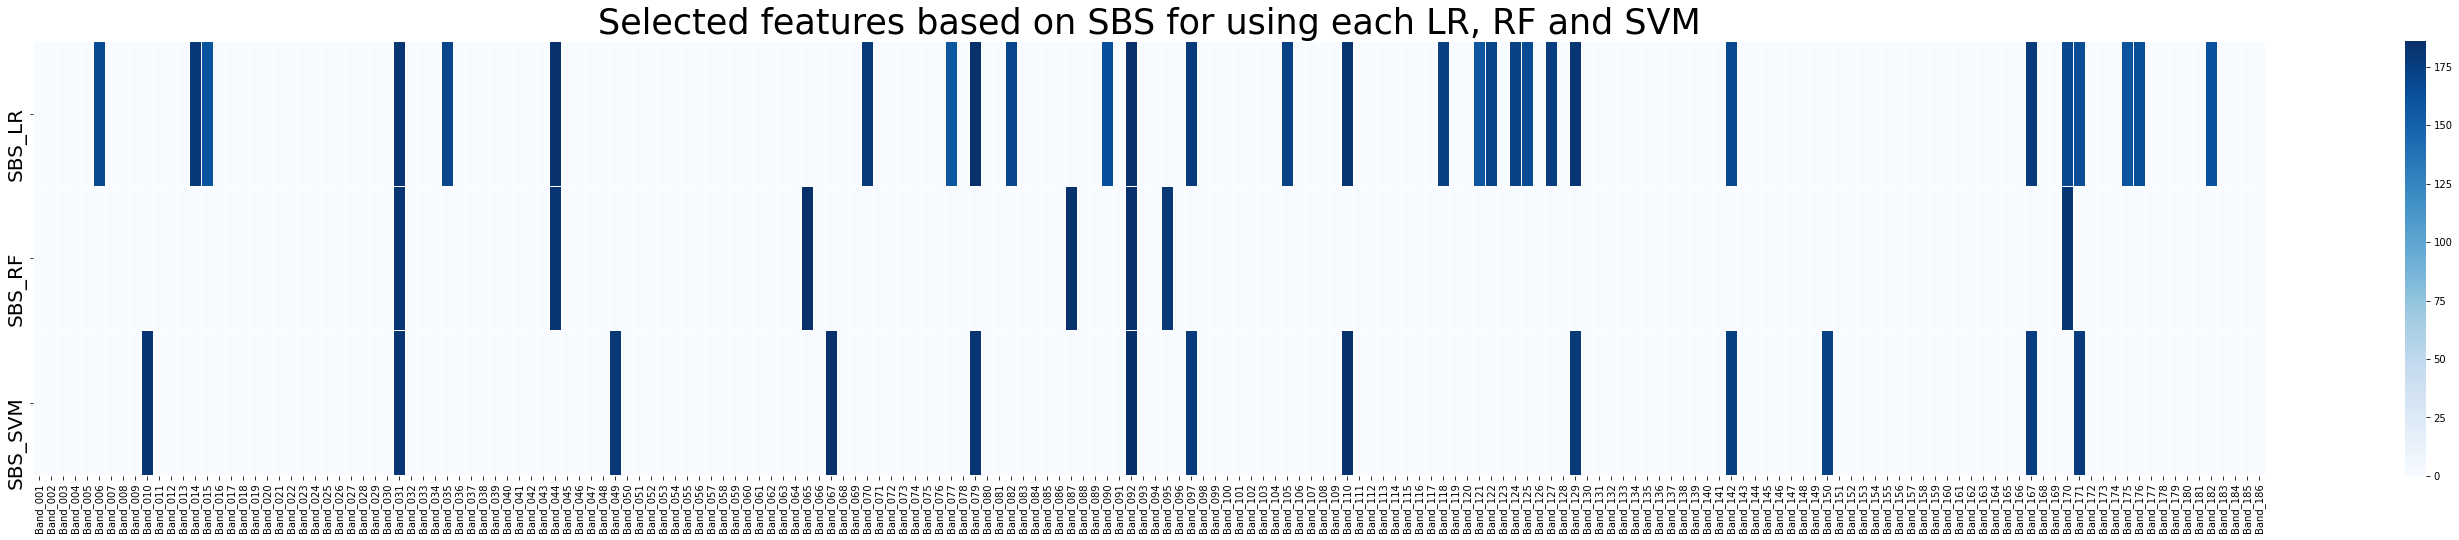

In [ ]:
fig, ax = plt.subplots(figsize=(50,8))
# ax.set_title('')
sns_plot = sns.heatmap(data=np.transpose(df.iloc[:,1:].values), annot=False, linewidths=0.01, cmap='Blues',
                       xticklabels=df.features.values[:], yticklabels=df.columns.values[1:], ax=ax)
plt.title('Selected features based on SBS for using each LR, RF and SVM', fontsize=35)
plt.yticks(fontsize=20)

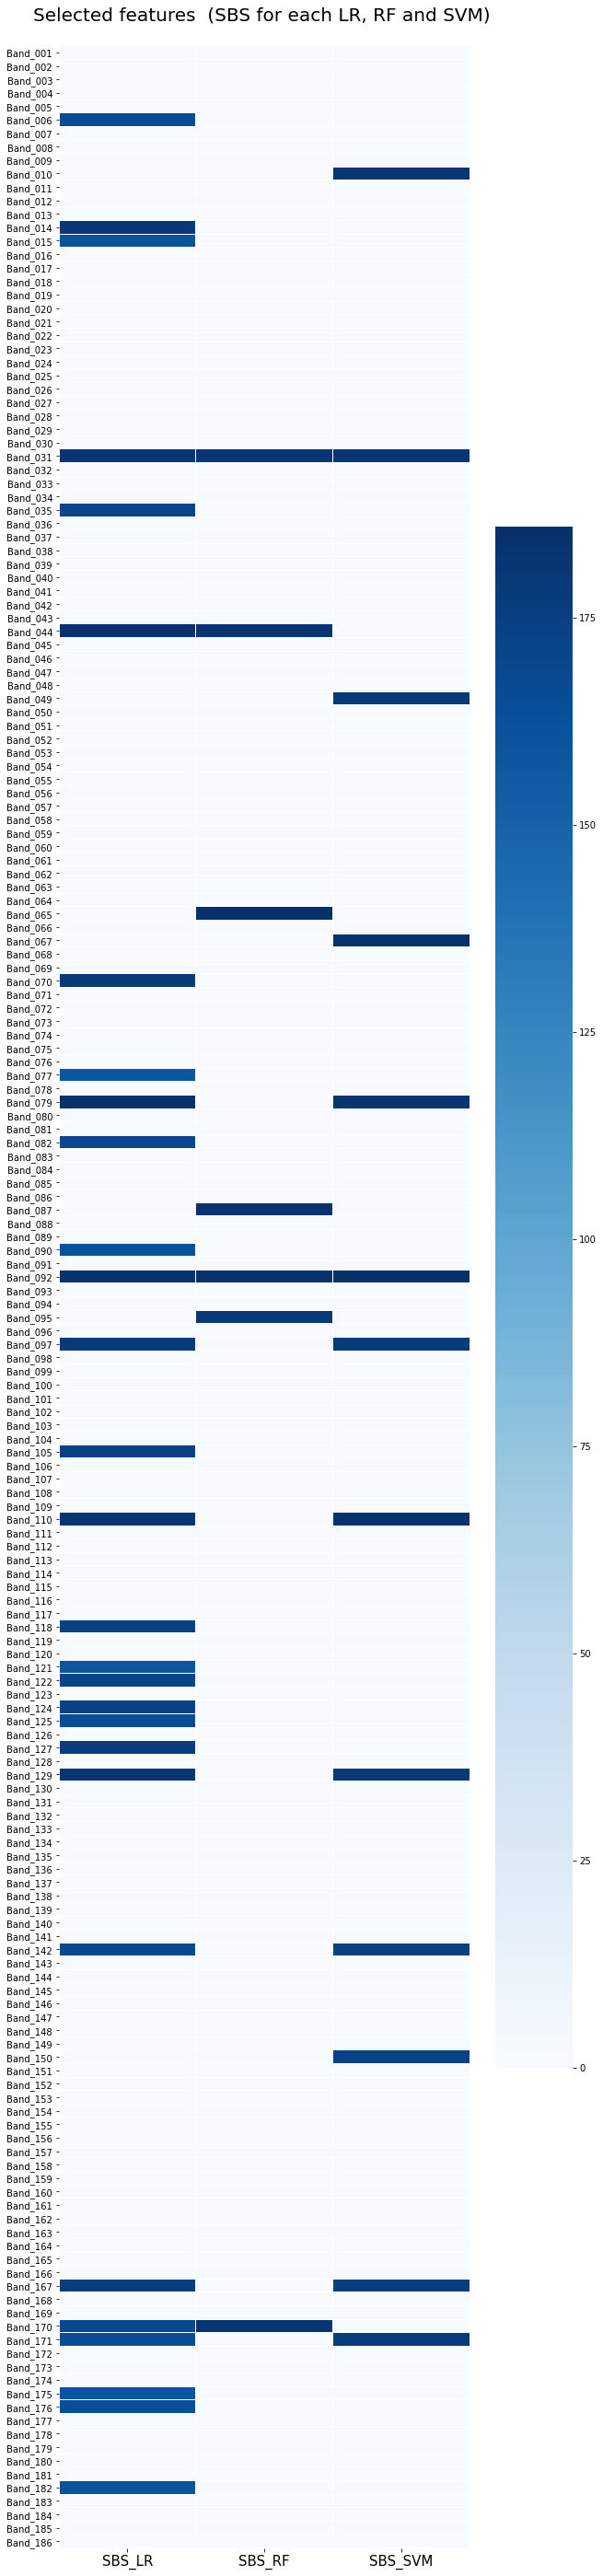

In [ ]:
fig, ax = plt.subplots(figsize=(10,50))
# ax.set_title('')
sns_plot = sns.heatmap(data=df.iloc[:,1:].values, annot=False, linewidths=0.01, cmap='Blues', 
                       yticklabels=df.features.values[:], xticklabels=df.columns.values[1:], ax=ax)

plt.title('Selected features  (SBS for each LR, RF and SVM) \n', fontsize=20)
plt.xticks(fontsize=15)
# plt.yticks(fontsize=20)
plt.show()

### SFS

In [ ]:
# ordered list of selected bands
SFS_LR_number_of_features = int(SFS_LR_number_features)

SFS_LR_ordered_list = list(set(SFS_LR_df.feature_names.values[0]))
for i in range(SFS_LR_number_of_features - 1):
  band = list(set(SFS_LR_df.feature_names.values[i+1]) - set(SFS_LR_df.feature_names.values[i]))
  SFS_LR_ordered_list.append(band[0])

# SFS_LR_ordered_list


# ordered list of selected bands
SFS_SVM_number_of_features = int(SFS_SVM_number_features)

SFS_SVM_ordered_list = list(set(SFS_SVM_df.feature_names.values[0]))
for i in range(SFS_SVM_number_of_features - 1):
  band = list(set(SFS_SVM_df.feature_names.values[i+1]) - set(SFS_SVM_df.feature_names.values[i]))
  SFS_SVM_ordered_list.append(band[0])

# SFS_SVM_ordered_list


# ordered list of selected bands
SFS_RF_number_of_features = int(SFS_RF_number_features)

SFS_RF_ordered_list = list(set(SFS_RF_df.feature_names.values[0]))
for i in range(SFS_RF_number_of_features - 1):
  band = list(set(SFS_RF_df.feature_names.values[i+1]) - set(SFS_RF_df.feature_names.values[i]))
  SFS_RF_ordered_list.append(band[0])

# SFS_SVM_ordered_list

In [ ]:
feature_names = np.array(list(set(SFS_LR_df.feature_names[-1:]))).flatten()

In [ ]:
df = pd.DataFrame(data=feature_names, columns=['features'])

In [ ]:
helper_df = pd.DataFrame(data=SFS_LR_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SFS_LR', value=np.arange(186, 186 - len(SFS_LR_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
helper_df = pd.DataFrame(data=SFS_RF_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SFS_RF', value=np.arange(186, 186 - len(SFS_RF_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
helper_df = pd.DataFrame(data=SFS_SVM_ordered_list, columns=['features'])
helper_df.insert(loc=1, column='SFS_SVM', value=np.arange(186, 186 - len(SFS_SVM_ordered_list), -1))
df = pd.merge(df, helper_df, how='outer', left_on='features', right_on='features')

In [ ]:
df.fillna(value=0, inplace=True)

In [ ]:
df.head(3)

,features,SFS_LR,SFS_RF,SFS_SVM
0,Band_001,0.0,0.0,0.0
1,Band_002,0.0,0.0,0.0
2,Band_003,0.0,0.0,0.0


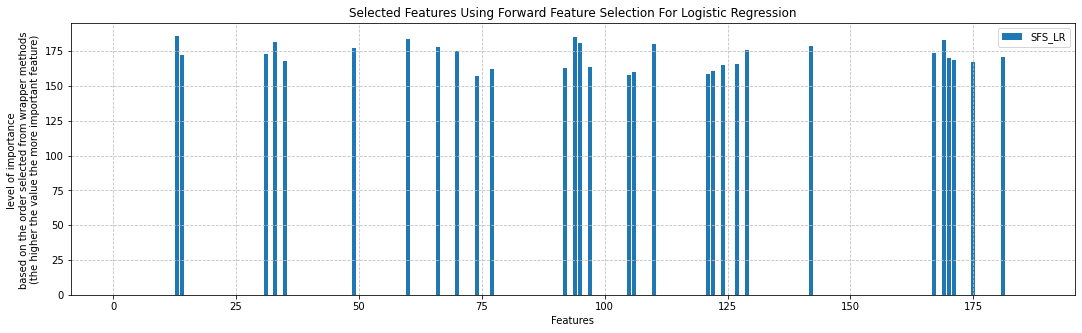

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SFS_LR, label="SFS_LR")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Forward Feature Selection For Logistic Regression')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

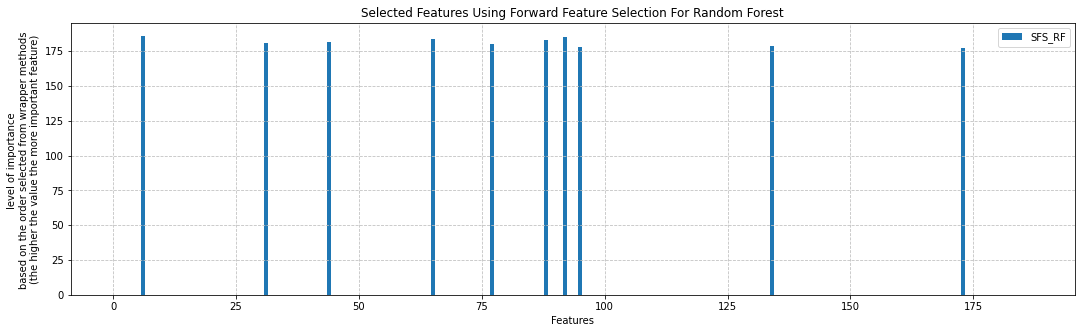

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SFS_RF, label="SFS_RF")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Forward Feature Selection For Random Forest')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

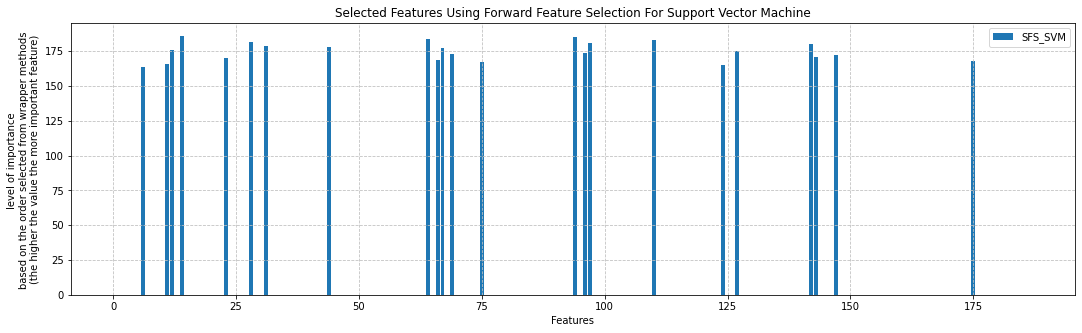

In [ ]:
plt.figure(figsize=(18, 5))
plt.bar(np.arange(186)+1, df.SFS_SVM, label="SFS_SVM")
plt.xlabel('Features')
plt.ylabel('level of importance \nbased on the order selected from wrapper methods \n(the higher the value the more important feature)')
plt.title('Selected Features Using Forward Feature Selection For Support Vector Machine')
plt.grid(b=True, which='major', color='silver', linestyle='--')
plt.legend(loc="best")
plt.show()

(array([0.5, 1.5, 2.5]), <a list of 3 Text major ticklabel objects>)

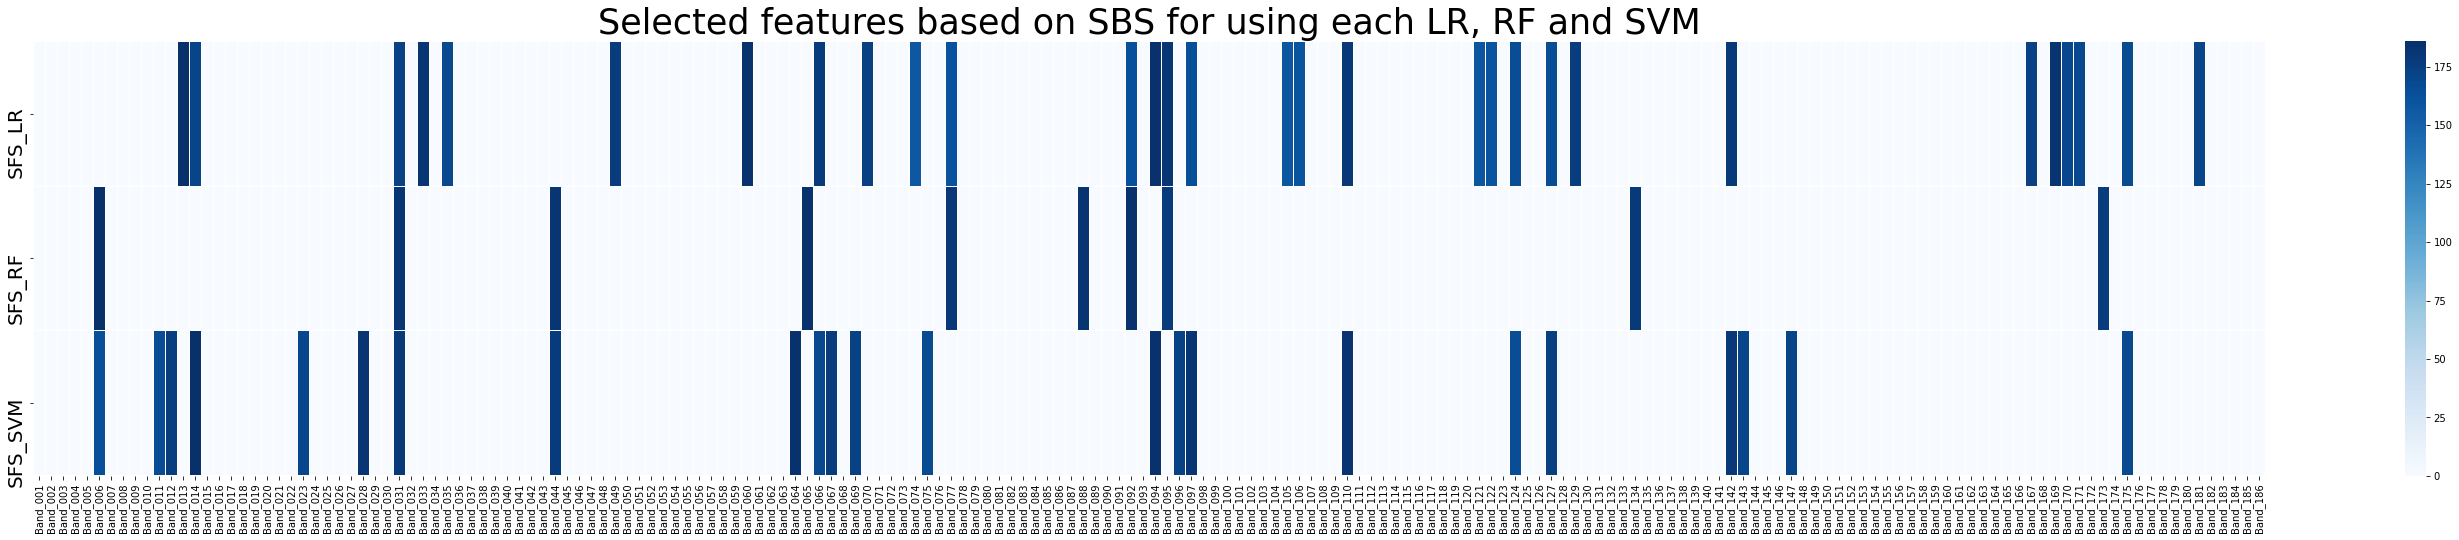

In [ ]:
fig, ax = plt.subplots(figsize=(50,8))
# ax.set_title('')
sns_plot = sns.heatmap(data=np.transpose(df.iloc[:,1:].values), annot=False, linewidths=0.01, cmap='Blues',
                       xticklabels=df.features.values[:], yticklabels=df.columns.values[1:], ax=ax)
plt.title('Selected features based on SBS for using each LR, RF and SVM', fontsize=35)
plt.yticks(fontsize=20)

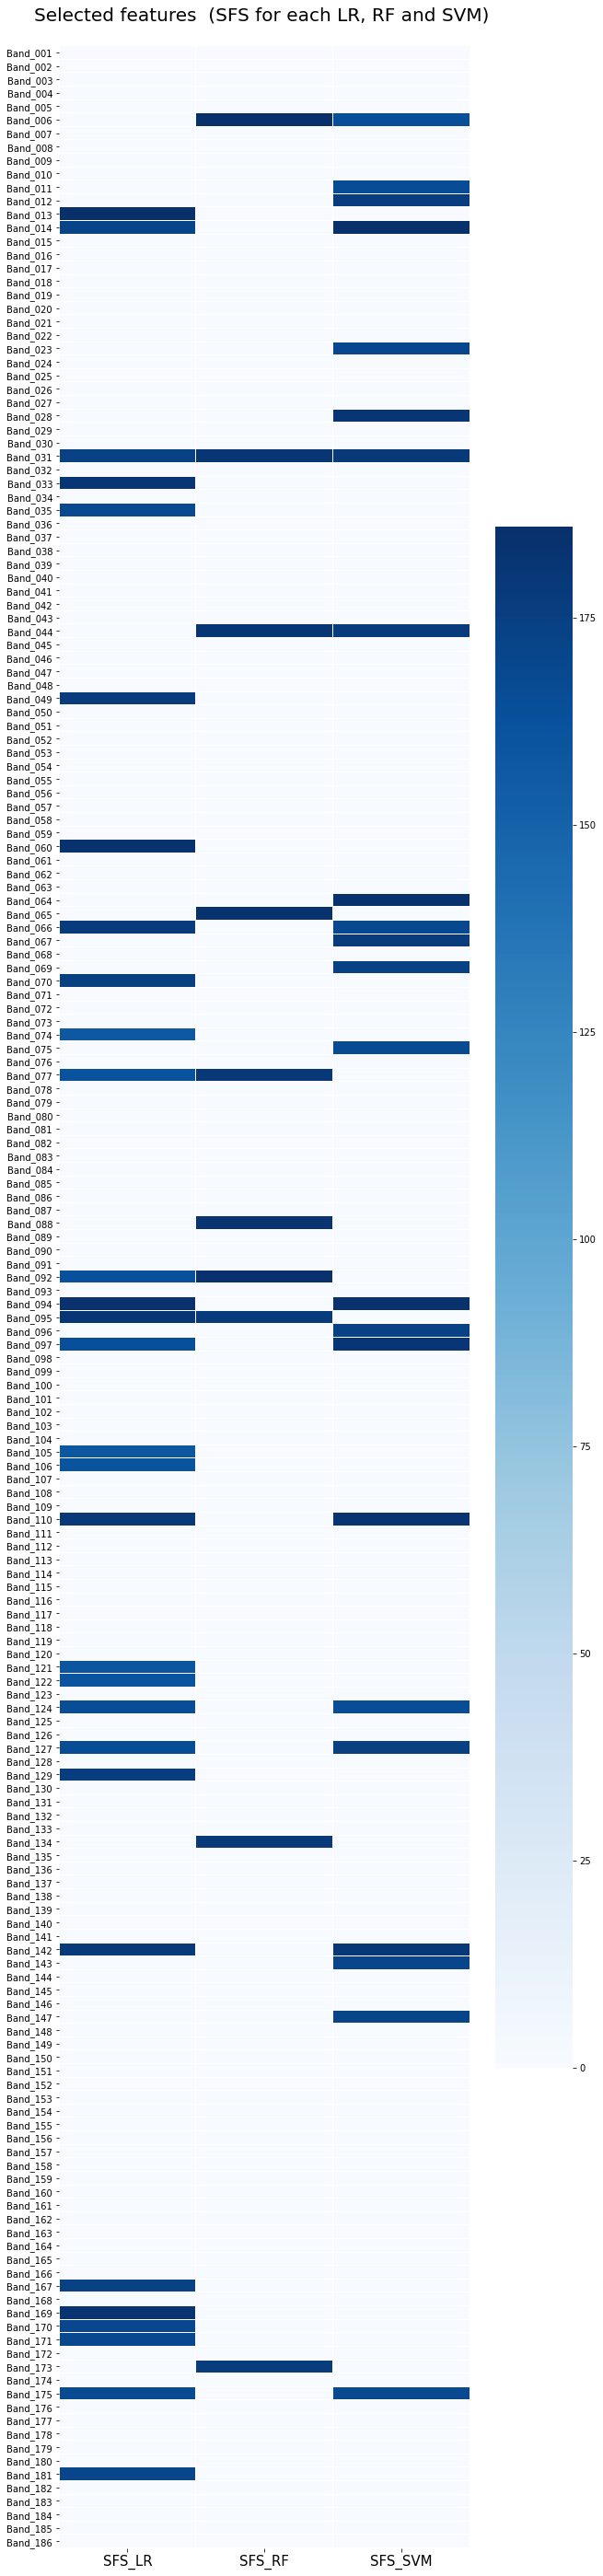

In [ ]:
fig, ax = plt.subplots(figsize=(10,50))
# ax.set_title('')
sns_plot = sns.heatmap(data=df.iloc[:,1:].values, annot=False, linewidths=0.01, cmap='Blues', 
                       yticklabels=df.features.values[:], xticklabels=df.columns.values[1:], ax=ax)

plt.title('Selected features  (SFS for each LR, RF and SVM) \n', fontsize=20)
plt.xticks(fontsize=15)
# plt.yticks(fontsize=20)
plt.show()

In [ ]:
# restart runtime and clear ram
import os, signal
os.kill(os.getpid(), signal.SIGKILL)